In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
import tensorflow as tf
import skimage.filters
import random
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
batch_size = 32
images = tf.keras.utils.image_dataset_from_directory('/tf/notebooks/data/cifar10/images', 
                                                     image_size = (32,32), 
                                                     batch_size = batch_size)

Found 10000 files belonging to 10 classes.


In [3]:
class_names = images.class_names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [4]:
count_class = len(images.class_names)

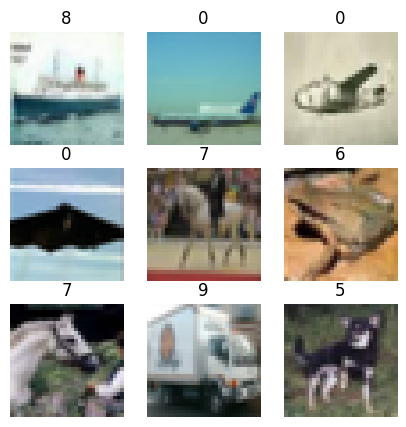

In [5]:
plt.figure(figsize=(5,5))
for im, lb in images.take(1):
    
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        
        plt.imshow(im[i].numpy().astype("uint8"))
        plt.title(class_names[lb[i]])
        plt.axis("off")


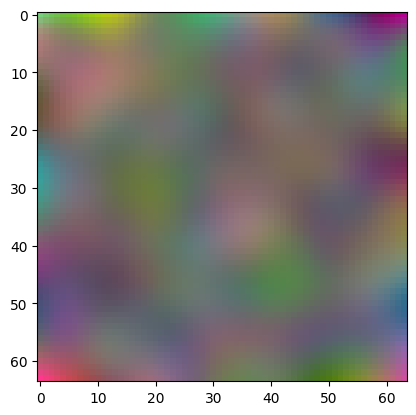

In [6]:
new_size = (64, 64)

def get_background():
    bg_source = np.random.rand(new_size[0], new_size[1], 3).astype(np.float32)
    bg_source = skimage.filters.gaussian(bg_source, 4, channel_axis=2)
    bg_source = (bg_source - np.min(bg_source))/(np.max(bg_source) - np.min(bg_source))
    bg_source = np.clip(bg_source, 0, 1)
    return bg_source

_=plt.imshow(get_background() ,'gray' )

In [133]:
#Список изображений и классов
path_list = sorted(glob.glob('/tf/notebooks/data/cifar10/images/*'))
images_list=[]   
images_class=[]


#Так как будем используем простую модель, уменьшим количество классов до двух
for i, val in enumerate(path_list[0:2]):
    #print(i)
    images_one_class_list= val + "/*.png"
    
    images_one_class_list = sorted(glob.glob(images_one_class_list))
    
    images_list += images_one_class_list
    images_class += [i]*len(images_one_class_list)


In [134]:
#Функция для загрузки изображения
def load_img_one(image):

    #Загружаем и препроцессим изображения
    image = tf.io.read_file(image)
    image = tf.io.decode_png(image)
    image = tf.image.resize(image, (32,32))
    #image = tf.image.rgb_to_grayscale(image)
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
   
    return image


def load_img(x, y):
      
    #Загружаем изображение
    x = load_img_one(x)
    y_new = np.zeros((10, 5), dtype=np.float32)
    x_new = np.zeros((new_size[0], new_size[1], 3), dtype=np.float32)
    
    bg_source = get_background() 
    
    rh = float(x.shape[0]) / new_size[0]
    rw = float(x.shape[1]) / new_size[1]
   
    oh = random.randint(0, bg_source.shape[0] - new_size[0])
    ow = random.randint(0, bg_source.shape[1] - new_size[1])
    x_new = bg_source[oh:oh+new_size[0], ow:ow+new_size[1], :]
    oh = random.randint(0, x_new.shape[0] - x.shape[0])
    ow = random.randint(0, x_new.shape[1] - x.shape[1])
    
    x_new[oh:oh+x.shape[0], ow:ow+x.shape[1], :] = x
    x_new = np.clip(x_new, 0, 1)
    ry = float(oh) / new_size[0]
    rx = float(ow) / new_size[1]
            
    y_new[y] = [1.0, ry, rx, rh, rw]
            
    return x_new, y_new

In [135]:
# свой генератор- для ищзменения исходных изображений 
def batch_img_gen(in_df, batch_size):
    out_x, out_y = [], []
    while True:
        for c_df in np.random.permutation(in_df):

            x, y = load_img(c_df[0], c_df[1])
            out_x += [x]
            out_y += [y]

            if len(out_x) >= batch_size:
                yield np.stack(out_x, 0), np.stack(out_y, 0)

                out_x, out_y = [], []
               

In [136]:
full_df = pd.DataFrame()
full_df["path"] = images_list
full_df["class"]= images_class

In [137]:
x_train, x_test, y_train, y_test = train_test_split(full_df["path"], full_df["class"], train_size = 0.7)

train_df = pd.DataFrame()
valid_df = pd.DataFrame()
train_df['x'] = x_train.values
train_df['y'] = y_train.values

valid_df['x'] = x_test.values
valid_df['y'] = y_test.values


In [138]:
BATCH_SIZE = 64
train_batches = batch_img_gen(train_df, BATCH_SIZE)
test_batches = batch_img_gen(valid_df, BATCH_SIZE)

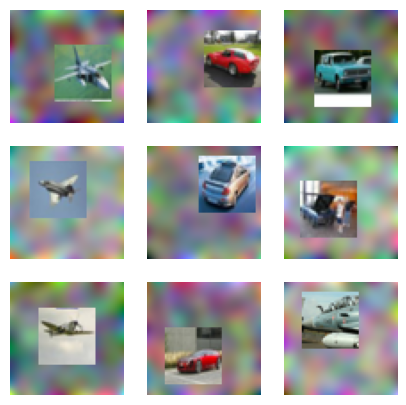

In [139]:
plt.figure(figsize=(5,5))
for im, lb in train_batches:
    #print(lb.shape)
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        
        plt.imshow(im[i], 'gray')
        
        #plt.title(lb[i])
        plt.axis("off")
    break


In [140]:
def show_prediction(x, logits):
    pred_cls = np.argmax(logits[:,0])
    ry, rx, rh, rw = logits[pred_cls][1:]

    box_y = round(ry * x.shape[0])
    box_x = round(rx * x.shape[1])
    box_h = round(rh * x.shape[0])
    box_w = round(rw * x.shape[1])

    fig,ax = plt.subplots(1)
    ax.imshow(x[...], vmin=0, vmax=1, cmap='gray')
    rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print('Prediction: {}'.format(pred_cls))
    print('Box: {}'.format((box_x, box_y, box_w, box_h)))

Prediction: 0
Box: (10, 6, 32, 32)


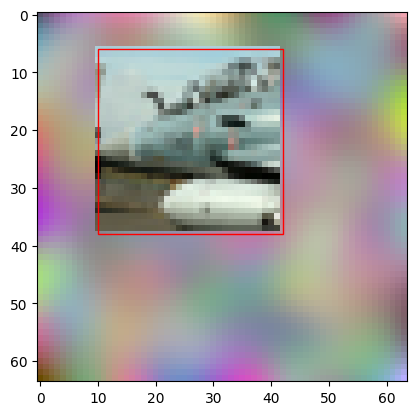

In [141]:
show_prediction(im[i], lb[i])

In [142]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(5*10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):
        
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = self.max_pool(out)
        out = self.conv4(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = tf.reshape(out, (-1, out.shape[1]//5, 5))
        
        return out
    
model = Model()

In [143]:
def loss_cls(labels, logits):
    logits_cls = logits[:,:,0]
    labels_cls = labels[:,:,0]
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        labels_cls, logits_cls, from_logits=True))

def loss_box(labels, logits):
    logits_box = logits[:,:,1:]
    labels_box = labels[:,:,1:]
    return tf.reduce_mean(tf.keras.losses.MSE(
        labels_box, logits_box))

LAMBDA = 10.0
def loss_composit(labels, logits):
    return loss_cls(labels, logits) + LAMBDA * loss_box(labels, logits)

In [144]:

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_composit)

Epoch 1/200
21/21 [==============================] - 1s 66ms/step - loss: 0.2378
Epoch 2/200
21/21 [==============================] - 1s 64ms/step - loss: 0.2107
Epoch 3/200
21/21 [==============================] - 1s 66ms/step - loss: 0.1971
Epoch 4/200
21/21 [==============================] - 1s 65ms/step - loss: 0.2271
Epoch 5/200
21/21 [==============================] - 1s 66ms/step - loss: 0.2062
Epoch 6/200
21/21 [==============================] - 1s 67ms/step - loss: 0.1705
Epoch 7/200
21/21 [==============================] - 1s 65ms/step - loss: 0.1834
Epoch 8/200
21/21 [==============================] - 1s 66ms/step - loss: 0.1570
Epoch 9/200
21/21 [==============================] - 1s 65ms/step - loss: 0.1654
Epoch 10/200
21/21 [==============================] - 1s 66ms/step - loss: 0.1713
Epoch 11/200
21/21 [==============================] - 1s 65ms/step - loss: 0.1876
Epoch 12/200
21/21 [==============================] - 1s 65ms/step - loss: 0.1412
Epoch 13/200
21/21 [=====

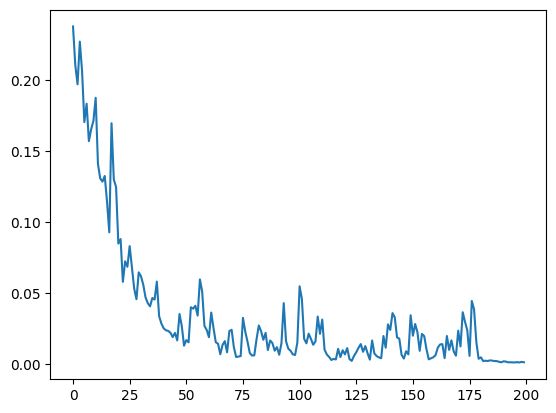

In [146]:
NUM_EPOCHS = 200
TRAIN_LENGTH = len(x_train)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 2
TEST_LENTH = len(x_test)
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

hist = model.fit(train_batches, epochs=NUM_EPOCHS, #validation_data=test_batches, 
                              steps_per_epoch=STEPS_PER_EPOCH)#,
                              #validation_steps=VALIDATION_STEPS)

plt.plot(hist.history['loss'])

In [147]:

t_x, t_y = next(test_batches)
if t_x.shape[0]>BATCH_SIZE:
    t_x = t_x[:BATCH_SIZE]
    t_y = t_y[:BATCH_SIZE]
pred_y = model.predict(t_x)
n = 0

2/2 [==============================] - 0s 2ms/step


Prediction: 0
Box: (20, 23, 32, 33)


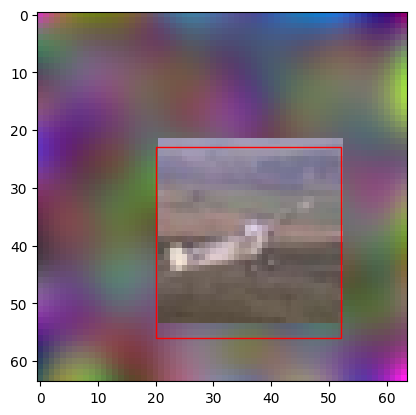

In [153]:
n = 5
show_prediction(t_x[n], pred_y[n])

Prediction: 1
Box: (27, -1, 31, 31)


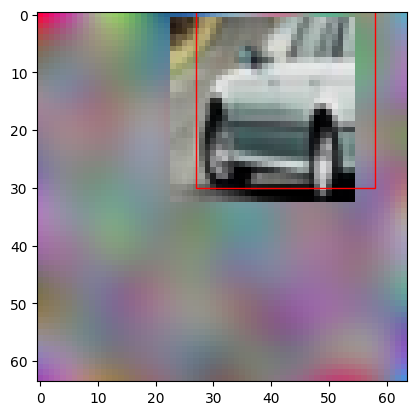

In [154]:
n = 4
show_prediction(t_x[n], pred_y[n])